In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Autoencoder and PCA

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.dynamics.dynamical_state import DynamicalState

In [3]:
store_results = True
load_models = False

## Introduction

## Implementation

In [4]:
def relaxed_distortion_measure(func, z, eta=0.2, create_graph=True):
    '''
    func: decoder that maps "latent value z" to "data", where z.size() == (batch_size, latent_dim)
    '''
    bs = len(z)
    z_perm = z[torch.randperm(bs)]
    alpha = (torch.rand(bs) * (1 + 2*eta) - eta).unsqueeze(1).to(z)
    z_augmented = alpha*z + (1-alpha)*z_perm
    v = torch.randn(z.size()).to(z)
    Jv = torch.autograd.functional.jvp(
        func, z_augmented, v=v, create_graph=create_graph)[1]
    TrG = torch.sum(Jv.view(bs, -1)**2, dim=1).mean()
    JTJv = (torch.autograd.functional.vjp(
        func, z_augmented, v=Jv, create_graph=create_graph)[1]).view(bs, -1)
    TrG2 = torch.sum(JTJv**2, dim=1).mean()
    return TrG2/TrG**2

class Autoencoder(pl.LightningModule, GenerativeModel):
    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.enc1 = nn.Linear(3, 64)
            self.encbn1 = nn.BatchNorm1d(num_features=64)
            self.enc2 = nn.Linear(64, 128)
            self.encbn2 = nn.BatchNorm1d(num_features=128)
            self.enc3 = nn.Linear(128, 128)
            self.encbn3 = nn.BatchNorm1d(num_features=128)
            self.enc4 = nn.Linear(128, 64)
            self.enc5 = nn.Linear(64, 2)

        def forward(self, z):
            x = F.elu(self.encbn1(self.enc1(z)))
            x = F.elu(self.encbn2(self.enc2(x)))
            x = F.elu(self.encbn3(self.enc3(x)))
            x = F.elu(self.enc4(x))
            x = self.enc5(x)
            return x

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.dec1 = nn.Linear(2, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            self.dec4 = nn.Linear(128, 64)
            self.dec5 = nn.Linear(64, 3)

        def forward(self, z):
            x = F.elu(self.decbn1(self.dec1(z)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            x = F.elu(self.dec4(x))
            x = self.dec5(x)
            return x
        
    def __init__(self):
        super().__init__()
        self._n_components = 2
        self.encoder = Autoencoder.Encoder()
        self.decoder = Autoencoder.Decoder()

    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()

        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=0)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=2000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def fit_latent_pca(self, X):
        # project to latent space
        X = self.encode(X)

        # train pca on latents
        self.pca = PCA(n_components=X.shape[-1], svd_solver='full', whiten=True)
        self.pca.fit(X)

    def encode(self, X):
        return self.encoder(X).detach().cpu()

    def decode(self, z):
        return self.decoder(z).detach().cpu()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, X):
        X_rec = self.decoder(self.encoder(X))
        
        se = - (X - X_rec).pow(2).sum(-1)
        
        return se

    def sample_posterior(self, n_samples):
        # sample pca
        pca_z_encodings = np.random.normal(
            0, 1,
            [n_samples, self.pca.n_components_])

        # decode in pca space
        z_encodings = torch.from_numpy(
            self.pca.inverse_transform(pca_z_encodings)
        ).float()

        # decode in ambient space
        return self.decode(z_encodings)

    def training_step(self, batch, batch_idx):
        batch = batch[0]
        z = self.encoder(batch)
        batch_rec = self.decoder(z)
        
        # CHANTENSDKFASDFASDKFADSRFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
        loss = F.mse_loss(batch_rec, batch) + 1e-2*relaxed_distortion_measure(self.decoder, z, eta=0.2, create_graph=True)

        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        batch = batch[0]

        loss = F.mse_loss(self.decoder(self.encoder(batch)), batch)

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                patience=100
            ),
            'monitor': 'train_loss'
        }

    def __str__(self):
        return 'irae'

## Experiment 1a: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/irae'

if store_results:
    result_save_path = '../results/swiss_roll/irae'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and Autoencoder.save_exists(model_save_path):
    model = Autoencoder.load(model_save_path)
else:
    model = Autoencoder()
    model.fit_model(
        X=dataset.train_loader(batch_size=512),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    model.fit_latent_pca(dataset.X_train)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 34.1 K
1 | decoder | Decoder | 34.1 K
------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
%tensorboard --logdir ../results/swiss_roll/irae

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]]])

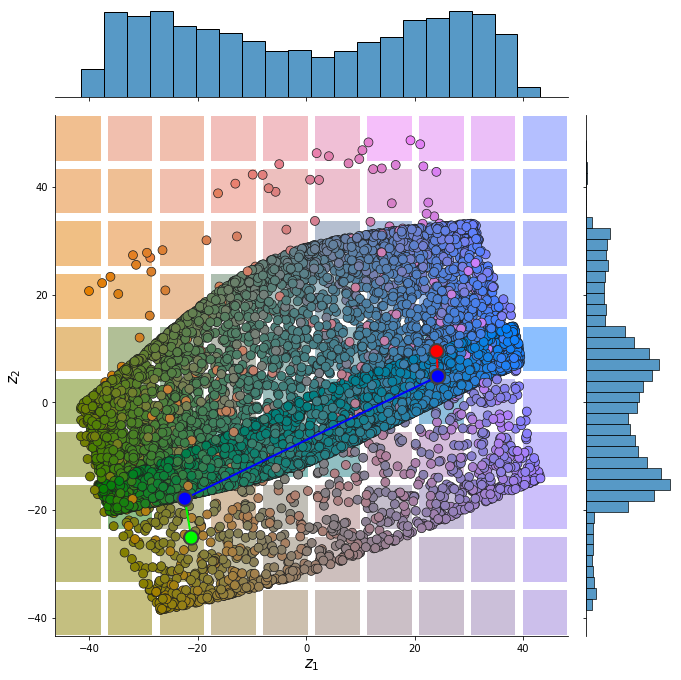

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X)
x = model.decode(z)

In [14]:
mse = (dataset.unnormalise_scale(dataset.X) - dataset.unnormalise_scale(x)).pow(2).sum(-1).mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'reconstruction.txt'), 'w') as f:
        f.write(str(mse.item()))
        
mse

tensor(9.7334)

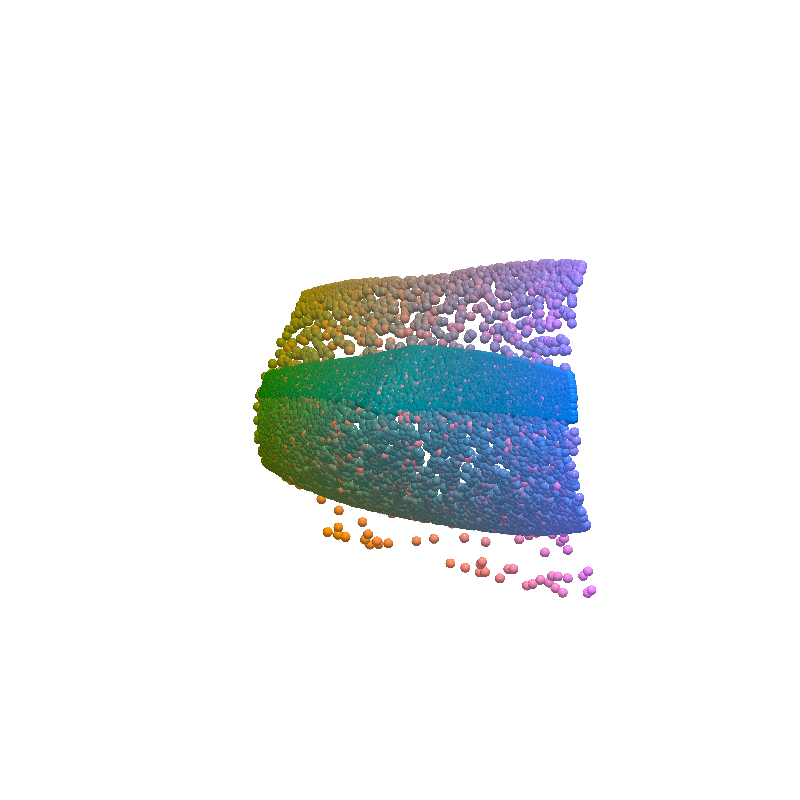

In [15]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors.numpy(), root=result_save_path)

### Density Estimation

In [16]:
from pdmtut.vis import plot_density
from regilib.core.invertible_modules.bijective import AffineTransform

In [17]:
log_likelihood = model.log_likelihood(dataset.X)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=dataset.X.clone().requires_grad_(True), log_prob=log_likelihood.clone()))

In [18]:
data_log_likelihood = data.log_prob.mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'density.txt'), 'w') as f:
        f.write(str(data_log_likelihood.item()))
        
data_log_likelihood

tensor(-7.6676, grad_fn=<MeanBackward0>)

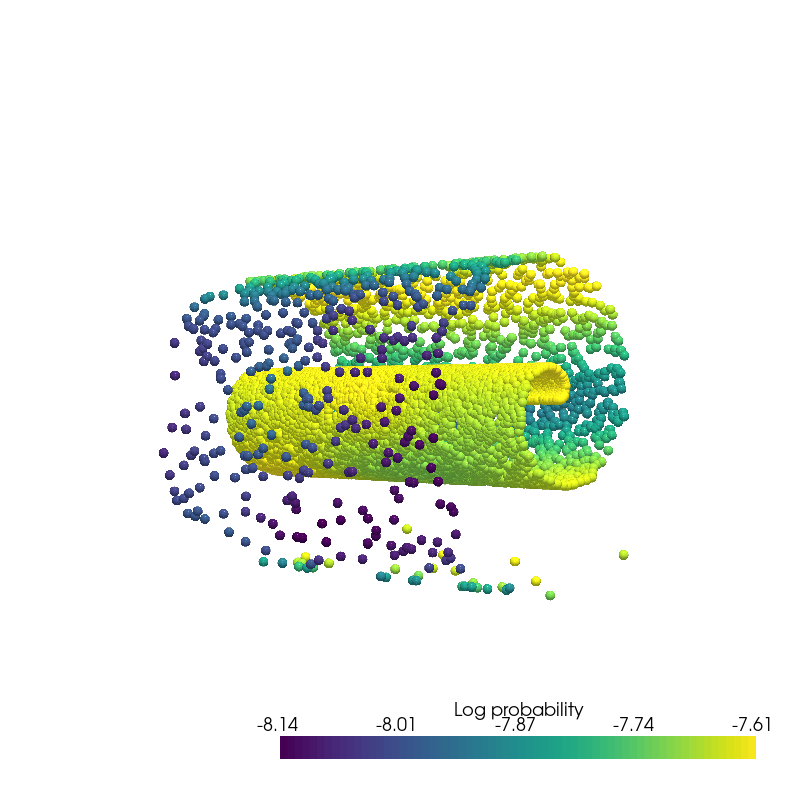

In [19]:
plot_density(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Generate Samples

In [20]:
from pdmtut.vis import plot_generated_samples
from regilib.core.invertible_modules.bijective import AffineTransform

In [21]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=generated_samples.clone().requires_grad_(True), log_prob=generated_samples_log_likelihood.clone()))

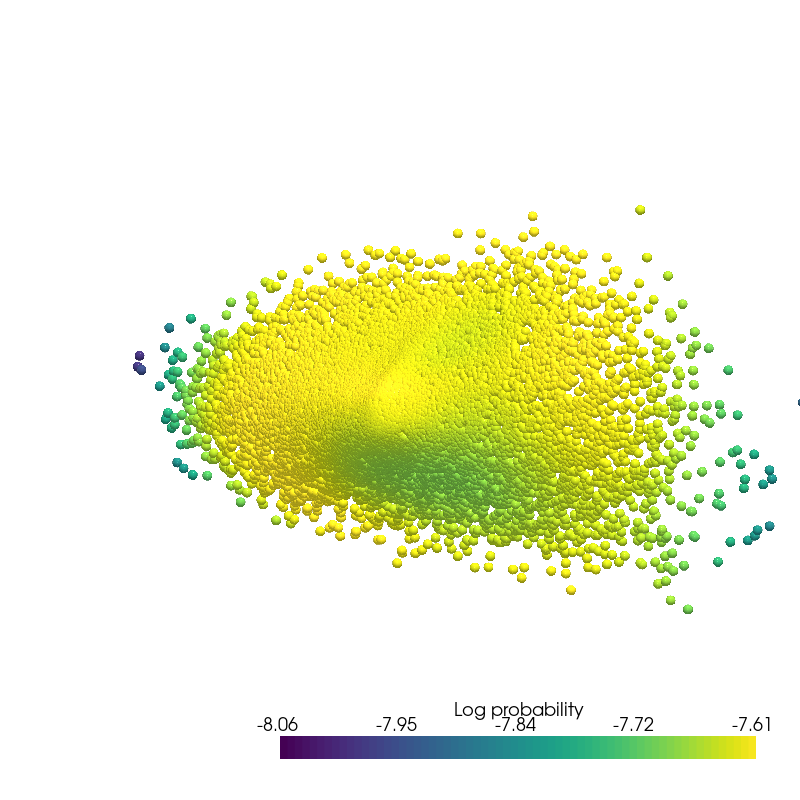

In [22]:
plot_generated_samples(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Interpolation

In [23]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [24]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3 = model.decode(torch.Tensor(linfit3(np.arange(1,21))))

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


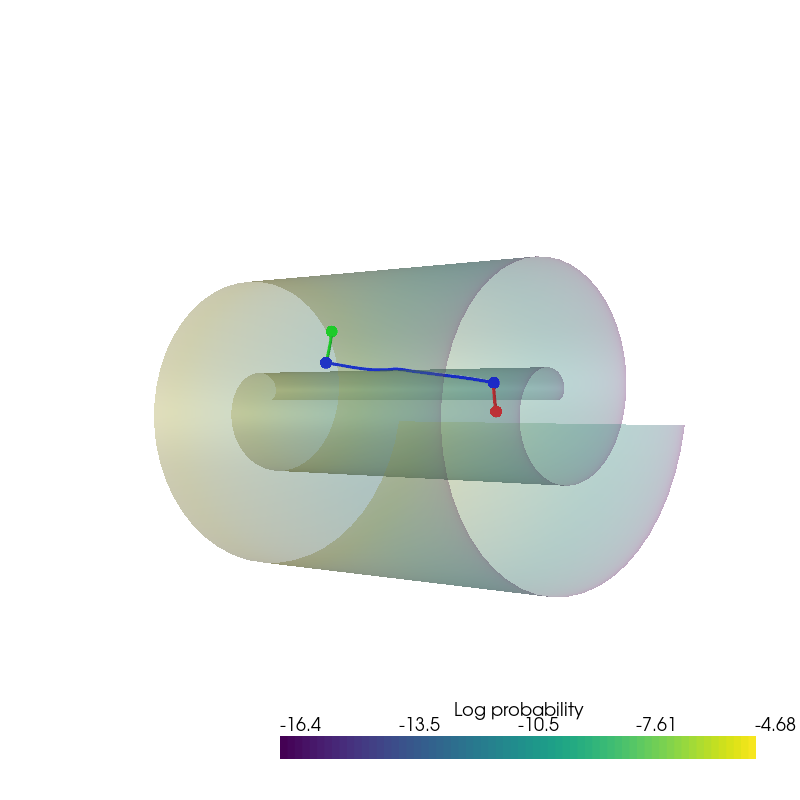

In [25]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    dataset.unnormalise_scale(interpolated_points_3).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)